In [1]:
import time

import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm

from jax.experimental import stax

In [2]:
EMBEDDING_SIZE = 1024
ITERATIONS_NUMBER = 100

In [3]:
# Taken from https://www.github.com/clementwalter/keras-fewshotlearning
def MixedNorms(input_shape, norms=None, use_bias=True):
    """
    Head inspired by
    [this kaggle notebook](https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563)
    on whale identification
    Args:
        input_shape (tuple): arg to be passed to keras.layer.Input
        norms (List[function]): list of function to be applied to the list of tensors [query, support] in a Lambda layer
        use_bias (bool), whether to use bias in layers or not
    """
    if norms is None:
        norms = [
            lambda x: x[0] * x[1],
            lambda x: x[0] + x[1],
            lambda x: tf.math.abs(x[0] - x[1]),
            lambda x: tf.math.square(x[0] - x[1])
        ]

    query = tf.keras.Input(input_shape)
    support = tf.keras.Input(input_shape)
    inputs = [query, support]
    if len(input_shape) == 4:
        inputs = [tf.keras.layers.GlobalAveragePooling2D()(input_) for input_ in inputs]

    output = tf.keras.layers.Concatenate()([tf.keras.layers.Lambda(norm)(inputs) for norm in norms])
    output = tf.keras.layers.Reshape((len(norms), inputs[0].shape[1], 1), name='reshape1')(output)

    output = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(len(norms), 1),
        activation='relu',
        padding='valid',
        name='norms_selection',
        use_bias=use_bias,
    )(output)
    output = tf.keras.layers.Reshape((inputs[0].shape[1], 32, 1))(output)
    output = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=(1, 32),
        activation='linear',
        padding='valid',
        name='norms_average',
        use_bias=use_bias,
    )(output)
    output = tf.keras.layers.Flatten()(output)

    output = tf.keras.layers.Dense(1, activation='sigmoid', name='output', use_bias=use_bias)(output)
    return tf.keras.Model(inputs=inputs, outputs=output)

In [4]:
# Initialize model and make a sample prediction to initialize all graph
tf_model = MixedNorms((EMBEDDING_SIZE,))
_ = tf_model.predict([np.random.random((4, EMBEDDING_SIZE)), np.random.random((4, EMBEDDING_SIZE))])

In [5]:
# Define norms with Jax
@jax.jit
def abs_norm(inputs):
    return jnp.abs(inputs[0] - inputs[1])

@jax.jit
def square_norm(inputs):
    return jnp.square(inputs[0] - inputs[1])

@jax.jit
def sum_norm(inputs):
    return inputs[0] + inputs[1]

@jax.jit
def mult_norm(inputs):
    return inputs[0] * inputs[1]

In [6]:
# Using vanilla Jax implementations
def inline_jax(inputs, first_conv_kernel, second_conv_kernel, dense_weights, dense_bias):
    norms = [
        abs_norm,
        square_norm,
        sum_norm,
        mult_norm,
    ]

    outputs = jnp.concatenate([norm(inputs) for norm in norms], axis=1)
    outputs = jnp.reshape(outputs, (inputs[0].shape[0], len(norms), inputs[0].shape[1], 1))
    outputs = jnp.transpose(outputs, [0, 3, 1, 2])
    outputs = jax.lax.conv(outputs, np.transpose(first_conv_kernel, [0, 3, 2, 1]), (1, 1), "VALID")
    outputs = jax.nn.relu(outputs)
    outputs = jax.lax.conv(outputs, np.transpose(second_conv_kernel, [0, 3, 2, 1]), (1, 1), "VALID")
    outputs = jnp.reshape(outputs, (inputs[0].shape[0], inputs[0].shape[1]))

    outputs = jnp.dot(outputs, jnp.transpose(dense_weights, [1, 0])) + dense_bias

    return outputs

# Format: IOHW
# Refer to https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#%F0%9F%94%AA-Convolutions
first_kernel = np.random.random((32, 1, 4, 1))
second_kernel = np.random.random((1, 1, 1, 32))

dense_weights = np.random.random((1, EMBEDDING_SIZE))
dense_bias = 0.17

In [7]:
# Using stax, the nn submodule of Jax
def MultiNormModule(norms):
    def init_fun(rng, input_shape):
        output_shape = (input_shape[0], len(norms), input_shape[1], 1)
        return output_shape, ()

    @jax.jit
    def apply_fun(params, inputs, **kwargs):

        outputs = jnp.concatenate([norm(inputs) for norm in norms], axis=1)
        outputs = jnp.reshape(outputs, (inputs[0].shape[0], len(norms), inputs[0].shape[1], 1))

        return outputs

    return init_fun, apply_fun

init_random_params, predict = stax.serial(
    MultiNormModule([
        abs_norm,
        square_norm,
        sum_norm,
        mult_norm,
    ]),
    jax.experimental.stax.Conv(32, (4, 1), padding="VALID"),
    jax.experimental.stax.Relu,
    jax.experimental.stax.Conv(16, (1, 32), padding="VALID"),
    jax.experimental.stax.Flatten,
    jax.experimental.stax.Dense(1),
    jax.experimental.stax.Sigmoid,
)
shape, params = init_random_params(jax.random.PRNGKey(0), (4, EMBEDDING_SIZE))
# Calling a first predict to initialize everything
_ = predict(params, [np.random.random((4, EMBEDDING_SIZE)), np.random.random((4, EMBEDDING_SIZE))])

/Users/ankur.kumar/tf2_env/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [8]:
durations = []

for batch_size in tqdm.tqdm([16*i for i in range(1, 20)]):
    # Running TensorFlow version ITERATIONS_NUMBER of times
    for _ in range(ITERATIONS_NUMBER):
        start_time = time.time()
        try:
            _ = tf_model.predict([np.random.random((batch_size, EMBEDDING_SIZE)), np.random.random((batch_size, EMBEDDING_SIZE))])
        except:
            print(batch_size)
        end_time = time.time()
        durations.append({
            "version": "tensorflow",
            "duration": end_time - start_time,
            "batch_size": batch_size,
        })

    # Running Jax version ITERATIONS_NUMBER of times
    for _ in range(ITERATIONS_NUMBER):
        start_time = time.time()
        inline_jax([
            np.random.random((batch_size, EMBEDDING_SIZE)),
            np.random.random((batch_size, EMBEDDING_SIZE))
        ], first_kernel, second_kernel, dense_weights, dense_bias)
        end_time = time.time()
        durations.append({
            "version": "jax",
            "duration": end_time - start_time,
            "batch_size": batch_size,
        })

    # Running jax.experimental.stax version ITERATIONS_NUMBER of times
    for _ in range(ITERATIONS_NUMBER):
        start_time = time.time()
        _ = predict(params, [np.random.random((batch_size, EMBEDDING_SIZE)), np.random.random((batch_size, EMBEDDING_SIZE))])
        end_time = time.time()
        durations.append({
            "version": "stax",
            "duration": end_time - start_time,
            "batch_size": batch_size,
        })

results = pd.DataFrame(durations)

100%|██████████| 19/19 [03:43<00:00, 11.75s/it]


In [9]:
results

,version,duration,batch_size
0,tensorflow,0.006763,16
1,tensorflow,0.005519,16
2,tensorflow,0.005132,16
3,tensorflow,0.005535,16
4,tensorflow,0.005583,16
...,...,...,...
5695,stax,0.101623,304
5696,stax,0.106973,304
5697,stax,0.101301,304
5698,stax,0.104863,304


In [21]:
results[(results.version=='jax')&(results.batch_size==16)].describe()

,duration,batch_size
count,100.000000,100.0
mean,0.021074,16.0
std,0.185877,0.0
min,0.002204,16.0
25%,0.002357,16.0
50%,0.002431,16.0
75%,0.002612,16.0
max,1.861255,16.0


Text(0.5, 1.0, 'CPU analysis')

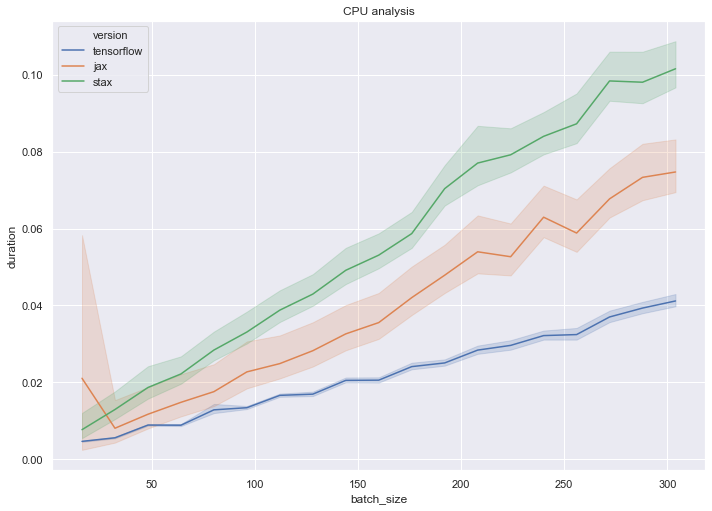

In [11]:
import seaborn as sns
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)})

# Plot the responses for different events and regions
sns.lineplot(x="batch_size", y="duration",
             hue="version",
             data=results).set_title("CPU analysis")  # Change title according to execution of this Colab.

Text(0.5, 1.0, 'CPU analysis')

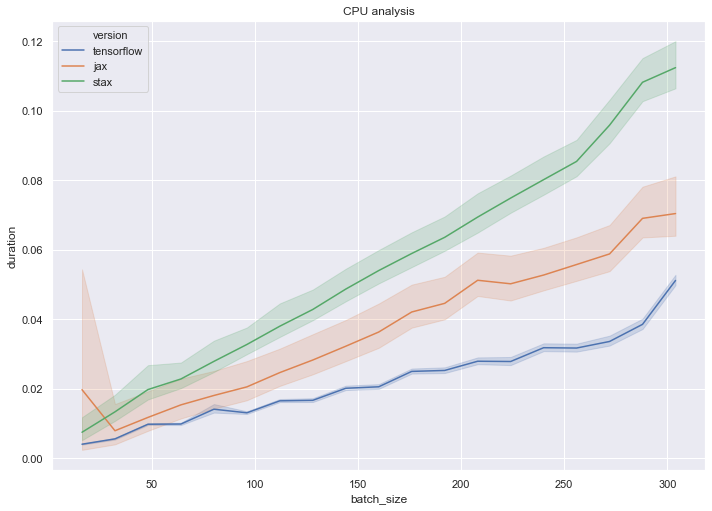

In [12]:
import seaborn as sns
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)})

# Plot the responses for different events and regions
sns.lineplot(x="batch_size", y="duration",
             hue="version",
             data=results).set_title("CPU analysis")  # Change title according to execution of this Colab.

Text(0.5, 1.0, 'CPU analysis')

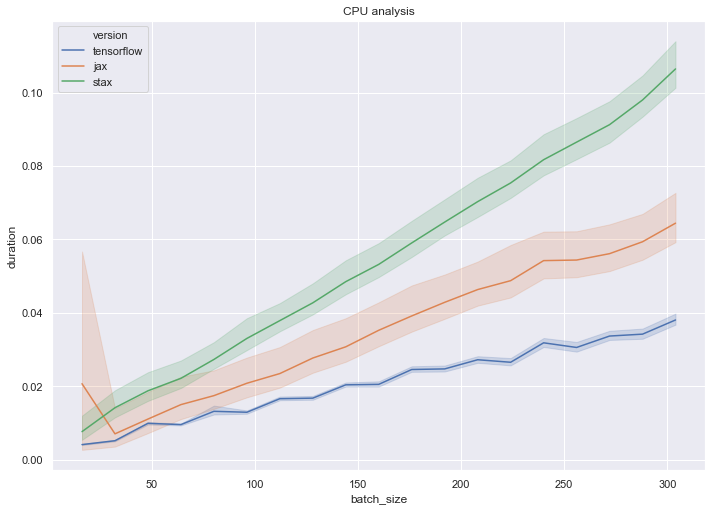

In [11]:
import seaborn as sns
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)})

# Plot the responses for different events and regions
sns.lineplot(x="batch_size", y="duration",
             hue="version",
             data=results).set_title("CPU analysis")  # Change title according to execution of this Colab.

Text(0.5, 1.0, 'CPU analysis')

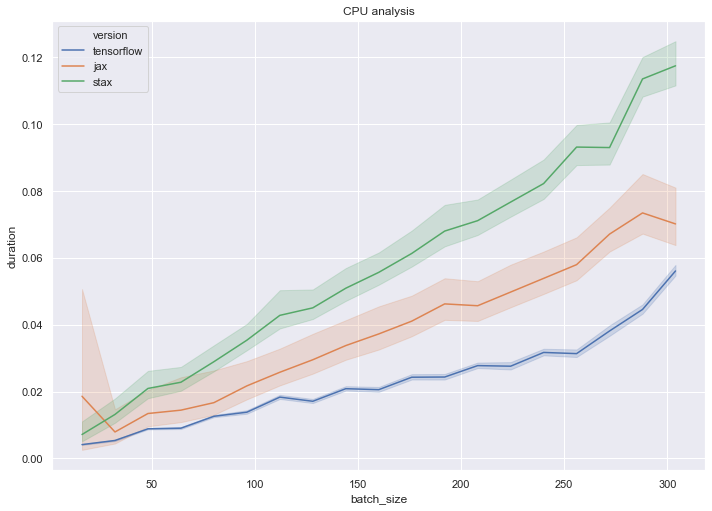

In [14]:
import seaborn as sns
sns.set(style="darkgrid", rc={'figure.figsize':(11.7,8.27)})

# Plot the responses for different events and regions
sns.lineplot(x="batch_size", y="duration",
             hue="version",
             data=results).set_title("CPU analysis")  # Change title according to execution of this Colab.